<a href="https://colab.research.google.com/github/ancastillar/Study-on-the-probability-of-payment-of-a-credit-requested-by-a-client/blob/main/Model_LOAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
# Cargar paquetes

import matplotlib.pyplot as plt
import numpy  as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as sfm
%matplotlib inline
from matplotlib.widgets import Slider, Button, RadioButtons
from scipy import interp
from scipy.optimize import fsolve
from scipy.stats import chi2_contingency, ttest_ind
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from statsmodels.formula.api import ols
import ipywidgets as widgets
from ipywidgets import interact
%matplotlib notebook
from IPython.display import display_html
plt.style.use('ggplot')

# LOGISTIC REGRESSION

In linear regression we were concerned with learning the coefficients of a polynomial to predict the response of a continuous variable $y_i$ on unseen data based on its independent variables $x_i$. However, a wide variety of problems, such as classification, are concerned with outcomestaking the form of discrete variables (i.e.  categories)

In Logistic regression, each set of features $\mathbf{x}_i$ is associated with a category $C_i\in\{1,0\}$, with $i=1\ldots n$. It is helpful to re-define $\mathbf{x}$ to be an extended vector $\mathbf{x}\rightarrow (1,\mathbf{x})$. Then, the Likelihood function for Logistic regression is given by the sigmoid function

$$
P(c_i=1)=1-P(c_i=0)= {1 \over 1+ e^{-\mathbf{w}\cdot \mathbf{x}_i}},
$$

where $\mathbf{w}$ are the weights that define the logistic regression. Notice that this is just the Fermi function with $\beta E=-\mathbf{w}\cdot \mathbf{x}$.

 We will maximize the Log-likelihood of the observed data. Let us define the function
$$
f(a)={1 \over 1+ e^{-a}},
$$
Notice that the derivative with respect to $a$ is given by
$$
{df \over da}= f(1-f).
$$

Define $f_i \equiv f(\mathbf{w}\cdot \mathbf{x}_i)$. Then, the Likelihood of the data $\{ \mathbf{x}_i, C_i \}$ is given by
$$
P(Data|\mathbf{x})= \prod_{i=1}^n f_i^{C_i}(1-f_i)^{1-C_i}
$$
and the log-likelihood is given by
$$
\log{P(Data|\mathbf{w})}= \sum_{i=1}^n C_i \log f_i + (1-C_i)\log(1-f_i)
$$

The negative of the log-likelihood gives us the cross-entropy error function
$$
\mathrm{Cross\,Entropy}=E(\mathbf{w})= -\sum_{i=1}^n C_i \log f_i + (1-C_i)\log(1-f_i).
$$

Using the formula above notice that
$$
\nabla E(\mathbf{w})=\sum_{i=1}^n (f_i-C_i)\mathbf{x}_i.
$$
In other words, the gradient points in the sum of training example directions weighted by the difference between the true label and the probability of predicting that label.



##Finding the MLE Estimate ##

Notice the Maximum-Likelihood Estimation (MLE) is the same as minimizing the cross-entropy. There is no closed form expression for this. One strategy is to start with an arbitrary $\mathbf{w}$ and then update our estimate based on our error function. In particular, we would like to nudge $\mathbf{w}$ in the direction where the error is decreasing the fastest. This is the idea behind gradient descent. Furthermore, we can show that the cross-entropy error function used in logistic regression has a unique minimum. Thus, we can perform this procedure with relative ease (However, as a word of caution, note there is a generic instability in the MLE procedure for linearly separable data).

Theoretically, one nice method for doing this is the <i> Newton-Raphson </i> method. In this method, we iteratively calculate the gradient 
$$
\mathbf{w}^{new} \leftarrow \mathbf{w}^{old} - \mathbf{H}^{-1} \nabla E(\mathbf{w}),
$$
where $\mathbf{H}$ is the Hessian matrix which is the second derivative of the energy function.[1]



Dataset

In [42]:
df=pd.read_csv('/content/drive/MyDrive/data_davivienda/Lending_club.csv')
#Transformation of variables

#Change loan_status, verification_status, emp_length, term and grade to category type 
df.loan_status = df.loan_status.astype(pd.api.types.CategoricalDtype(categories=['Charged Off', 'Fully Paid']))
df.verification_status = df.verification_status.astype(pd.api.types.CategoricalDtype(categories=['Not Verified', 'Source Verified', 'Verified']))
df.emp_length = df.emp_length.astype(pd.api.types.CategoricalDtype(categories=['< 1 year', '1 year', '2 years', '3 years', '4 years', \
                                                             '5 years', '6 years', '7 years', '8 years', '9 years', \
                                                             '10+ years']))
df.home_ownership = df.home_ownership.astype(pd.api.types.CategoricalDtype(categories=['RENT','MORTGAGE','OWN','OTHER']))
df.term = df.term.astype(pd.api.types.CategoricalDtype(categories=[' 36 months', ' 60 months']))
df.grade = df.grade.astype(pd.api.types.CategoricalDtype(categories=['A','B','C','D','E','F','G']))
df.purpose = df.purpose.astype(pd.api.types.CategoricalDtype(categories=['debt_consolidation','credit_card','other','home_improvement','major_purchase','small_business','car', 'wedding','medical','moving','house','vacation','educational','renewable_energy']))

#In addition, the original data in int_rate contains strings of the form 'x.xx%',
#we remove the % and change the vaules to float:
df.int_rate = df.int_rate.str.rstrip('%').astype('float')

In [43]:
df_log1 = pd.DataFrame(columns=['verification_status','loan_status'])
df_log1['verification_status'] = df.verification_status.cat.codes
df_log1['loan_status'] = df.loan_status.cat.codes
df_log1['Intercept'] = 1

logit = sm.Logit(df_log1['loan_status'], df_log1[['Intercept','verification_status']])
logit_res = logit.fit()
logit_res.summary()



Optimization terminated successfully.
         Current function value: 0.405007
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            loan_status   No. Observations:                38705
Model:                          Logit   Df Residuals:                    38703
Method:                           MLE   Df Model:                            1
Date:                Wed, 25 Nov 2020   Pseudo R-squ.:                0.002350
Time:                        21:36:14   Log-Likelihood:                -15676.
converged:                       True   LL-Null:                       -15713.
Covariance Type:            nonrobust   LLR p-value:                 8.419e-18
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               1.9469      0.022     88.290      0.000       1.904       1.990
verification_status    -0.1460      0.017     -8.600      0.000      -0.179      -0.113
=======================================================================================
"""

Now we are going to study the relationship between the variables: <code>loan_status</code>,<code>loan_amount</code> and <code>int_rate</code>. We are proceeding similar to before:

In [44]:
df6=df.copy()
df6['loan_status'] = df6.loan_status.cat.codes
df6['loan_amnt']=(df6['loan_amnt']-df6['loan_amnt'].mean())/df6['loan_amnt'].std()
df6['int_rate']=(df6['int_rate']-df6['int_rate'].mean())/df6['int_rate'].std()
df6['Intercept'] = 1

logit2 = sm.Logit(df6['loan_status'], df6[['Intercept','loan_amnt','int_rate']])
logit_res2 = logit2.fit()
logit_res2.summary()

Optimization terminated successfully.
         Current function value: 0.386118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            loan_status   No. Observations:                38705
Model:                          Logit   Df Residuals:                    38702
Method:                           MLE   Df Model:                            2
Date:                Wed, 25 Nov 2020   Pseudo R-squ.:                 0.04888
Time:                        21:36:16   Log-Likelihood:                -14945.
converged:                       True   LL-Null:                       -15713.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.9277      0.016    119.842      0.000       1.896       1.959
loan_amnt      0.0399      0.015      2.664      0.008       0.011       0.069
int_rate      -0.5862      0.016    -36.901      0.000      -0.617      -0.555
==============================================================================
"""

<h3>The Receiver Operating Characteristic (ROC) curve</h3>
<p>We have seen the great potential in considering the TPR and TNR to help select the appropriate threshold for our models. However, it does not makes much sense to compute these for single cut-off values. We ought to summarize the prediction accuracy across all different cut-off values to produce a unified evalution of our model. This is the motivation for the <strong>receiver operating characteristic (ROC) curve</strong>.</p>
<p>The ROC curve plots 1 - TNR against TPR and illustrates the behavior of a logistic model as the cut-off point changes.</p>

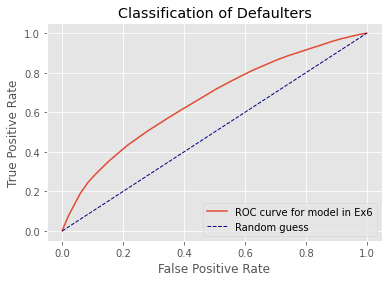

In [49]:
%matplotlib inline
def rates(p):
    a= df6.loan_status
    b=(b_Intercept+b_loan_amnt*df6['loan_amnt']+b_int_rate*df6['int_rate']>np.log(p/(1-p))).astype('int')
    
    TPR=(a & b).sum(axis=0)/a.sum(axis=0)
    TNR=(1-a & 1-b).sum(axis=0)/(1-a).sum(axis=0)
    return [TPR,TNR]

#Luego, usamos esta función para trazar la curva ROC
x=[]
y=[]
for p in np.arange(0.01,0.99,0.01):
    z=rates(p)
    y.append(z[0])
    x.append(1-z[1])
    
fig, ax = plt.subplots()

ax.plot(x,y, label=f'ROC curve for model in Ex6')
ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classification of Defaulters')
plt.legend(loc='lower right');

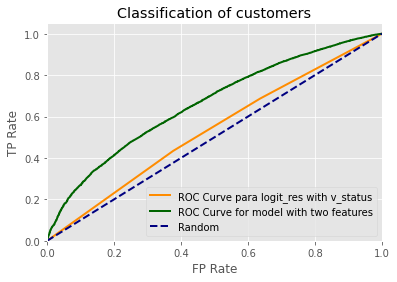

In [57]:
%matplotlib inline
predict_p = logit_res.predict(df_log1[['Intercept','verification_status']])
predict_2_p = logit_res2.predict(df6[['Intercept','loan_amnt','int_rate']])
roc_p = roc_curve(df_log1['loan_status'], predict_p)
roc_2_p = roc_curve(df6['loan_status'], predict_2_p)

plt.figure()
line_width = 2
plt.plot(roc_p[0], roc_p[1], color='darkorange',
         lw=line_width, label=f'ROC Curve para logit_res with v_status')
plt.plot(roc_2_p[0], roc_2_p[1], color='darkgreen',
         lw=line_width, label=f'ROC Curve for model with two features')
plt.plot([0, 1], [0, 1], color='navy', lw=line_width, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')
plt.title('Classification of customers')
plt.legend(loc='lower right')
plt.show()

#Evaluation of classification models (Theory)

##Confusion Matrix##
The general idea is to count the number of times instances of class A are classified as class B. To compute the confusion  matrix, you first need to have a set of predictions so that they  can  be  compared  to  the  actual  targets. You could make predictions on  the  test set,  but  let's  keep  it  untouched  for  now  (remember  that  you  want  to  use  the  test  set only  at  the  very  end  of  your  project,  once  you  have  a  classifier  that  you  are  ready  to launch). Instead, you can use the cross_val_predict() function:


#REFERENCES:

[1] Pankaj Mehta, Ching-Hao Wang, Alexandre G. R. Day, and Clint Richardson,  *A high-bias, low-variance introduction to Machine Learning for physicists*. 27 May 2019.  https://arxiv.org/pdf/1803.08823.pdf